In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-07-01 10:52:13 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-07-01 10:52:13 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-07-01 10:52:13 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

[2025-07-01 10:52:16,589] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-07-01 10:52:16 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -c /tmp/tmp_ow0cf15/test.c -o /tmp/tmp_ow0cf15/test.o
2025-07-01 10:52:16 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat /tmp/tmp_ow0cf15/test.o -laio -o /tmp/tmp_ow0cf15/a.out


/disk/u/arnab/miniconda3/envs/connection/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


2025-07-01 10:52:17 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -O2 -isystem /disk/u/arnab/miniconda3/envs/connection/include -fPIC -c /tmp/tmpfksjxl9a/test.c -o /tmp/tmpfksjxl9a/test.o
2025-07-01 10:52:17 root INFO     gcc -pthread -B /disk/u/arnab/miniconda3/envs/connection/compiler_compat /tmp/tmpfksjxl9a/test.o -L/usr -L/usr/lib64 -lcufile -o /tmp/tmpfksjxl9a/a.out


/disk/u/arnab/miniconda3/envs/connection/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


2025-07-01 10:52:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-01 10:52:18 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-01 10:52:18 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-07-01 10:52:18 wandb.docker.auth DEBUG    No config file found


## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-07-01 10:52:19 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-07-01 10:52:19 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-07-01 10:52:19 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-07-01 10:52:19 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-07-01 10:53:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-07-01 10:53:10 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001",
    model_key.split("/")[-1],
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas["model<>layers<>10<>mlp<>gate_proj"]
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-07-01 10:53:42 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-01 10:53:43 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
202

## Loading the Analysis Samples

In [8]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
# ----------------------------------------------------------


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching",
    SYNTH_DATASET,
    target_attribute,
)
samples_path = os.path.join(activation_patching_path, "samples.json")

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
1 => Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2 => Takeshi Yamamoto | Yuki Tanaka => " Japanese" | <-- | Rahman Ali => " Civil"
3 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
4 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
5 => Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
6 => Hans Mueller | Anna Schmidt => " German" | <-- | Ayse Kaya => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
10 => Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
11 => Kwame Mensah | Rahman Ali => " Doctor" | <-- | Min-jun Park => " Ge"
12 => Tran Thi Mai 

In [9]:
sample.common_entity, sample.patched_entity

('Rodrigo Gonzalez', 'Maria dela Rosa')

In [10]:
nat_and_prof = [
    {
        "entity_pair": ["William Shakespeare", "Christopher Marlowe"],
        "desc": "both William Shakespeare and Christopher Marlowe are playwrights and English",
    },
    {
        "entity_pair": ["Leonardo da Vinci", "Michelangelo"],
        "desc": "both Leonardo da Vinci and Michelangelo are artists and Italian",
    },
    {
        "entity_pair": ["Marie Curie", "Pierre Curie"],
        "desc": "both Marie Curie and Pierre Curie are physicists and French",
    },
    {
        "entity_pair": ["Mark Twain", "Ernest Hemingway"],
        "desc": "both Mark Twain and Ernest Hemingway are writers and American",
    },
    {
        "entity_pair": ["Albert Einstein", "Werner Heisenberg"],
        "desc": "both Albert Einstein and Werner Heisenberg are physicists and German",
    },
    {
        "entity_pair": ["Charlie Chaplin", "Buster Keaton"],
        "desc": "both Charlie Chaplin and Buster Keaton are actors and British",
    },
    {
        "entity_pair": ["Frida Kahlo", "Diego Rivera"],
        "desc": "both Frida Kahlo and Diego Rivera are painters and Mexican",
    },
    {
        "entity_pair": ["Akira Kurosawa", "Yasujiro Ozu"],
        "desc": "both Akira Kurosawa and Yasujiro Ozu are film directors and Japanese",
    },
    {
        "entity_pair": ["Victor Hugo", "Alexandre Dumas"],
        "desc": "both Victor Hugo and Alexandre Dumas are writers and French",
    },
    {
        "entity_pair": ["Confucius", "Lao Tzu"],
        "desc": "both Confucius and Lao Tzu are philosophers and Chinese",
    },
    {
        "entity_pair": ["Beethoven", "Bach"],
        "desc": "both Beethoven and Bach are composers and German",
    },
    {
        "entity_pair": ["Plato", "Aristotle"],
        "desc": "both Plato and Aristotle are philosophers and Greek",
    },
    {
        "entity_pair": ["Charles Darwin", "Isaac Newton"],
        "desc": "both Charles Darwin and Isaac Newton are scientists and British",
    },
    {
        "entity_pair": ["Rabindranath Tagore", "Satyajit Ray"],
        "desc": "both Rabindranath Tagore and Satyajit Ray are artists and Indian",
    },
    {
        "entity_pair": ["Voltaire", "Rousseau"],
        "desc": "both Voltaire and Rousseau are philosophers and French",
    },
    {
        "entity_pair": ["Galileo Galilei", "Enrico Fermi"],
        "desc": "both Galileo Galilei and Enrico Fermi are physicists and Italian",
    },
    {
        "entity_pair": ["Anton Chekhov", "Leo Tolstoy"],
        "desc": "both Anton Chekhov and Leo Tolstoy are writers and Russian",
    },
    {
        "entity_pair": ["Pablo Picasso", "Salvador Dalí"],
        "desc": "both Pablo Picasso and Salvador Dalí are painters and Spanish",
    },
    {
        "entity_pair": ["Thomas Edison", "Benjamin Franklin"],
        "desc": "both Thomas Edison and Benjamin Franklin are inventors and American",
    },
    {
        "entity_pair": ["Coco Chanel", "Christian Dior"],
        "desc": "both Coco Chanel and Christian Dior are fashion designers and French",
    },
]

prof_diff_nat = [
    {
        "entity_pair": ["Stephen King", "Haruki Murakami"],
        "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers",
    },
    {
        "entity_pair": ["Albert Einstein", "Stephen Hawking"],
        "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists",
    },
    {
        "entity_pair": ["Vincent van Gogh", "Frida Kahlo"],
        "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters",
    },
    {
        "entity_pair": ["Mozart", "Tchaikovsky"],
        "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers",
    },
    {
        "entity_pair": ["Marie Curie", "Rosalind Franklin"],
        "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists",
    },
    {
        "entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"],
        "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors",
    },
    {
        "entity_pair": ["Socrates", "Confucius"],
        "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers",
    },
    {
        "entity_pair": ["Meryl Streep", "Sophia Loren"],
        "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses",
    },
    {
        "entity_pair": ["Gabriel García Márquez", "Charles Dickens"],
        "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers",
    },
    {
        "entity_pair": ["Pelé", "Diego Maradona"],
        "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers",
    },
    {
        "entity_pair": ["Frank Lloyd Wright", "Le Corbusier"],
        "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects",
    },
    {
        "entity_pair": ["Nikola Tesla", "Thomas Edison"],
        "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors",
    },
    {
        "entity_pair": ["Sigmund Freud", "Carl Jung"],
        "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists",
    },
    {
        "entity_pair": ["Andy Warhol", "Banksy"],
        "desc": "both Andy Warhol (American) and Banksy (British) are artists",
    },
    {
        "entity_pair": ["Cristiano Ronaldo", "Lionel Messi"],
        "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers",
    },
    {
        "entity_pair": ["Beethoven", "Chopin"],
        "desc": "both Beethoven (German) and Chopin (Polish) are composers",
    },
    {
        "entity_pair": ["Audrey Hepburn", "Marilyn Monroe"],
        "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses",
    },
    {
        "entity_pair": ["Immanuel Kant", "René Descartes"],
        "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers",
    },
    {
        "entity_pair": ["Virginia Woolf", "Jane Austen"],
        "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers",
    },
    {
        "entity_pair": ["Claude Monet", "Pablo Picasso"],
        "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters",
    },
]

nat_diff_prof = [
    {
        "entity_pair": ["Albert Einstein", "Steven Spielberg"],
        "desc": "both Albert Einstein (physicist) and Steven Spielberg (film director) are American",
    },
    {
        "entity_pair": ["Winston Churchill", "The Beatles"],
        "desc": "both Winston Churchill (politician) and The Beatles (musicians) are British",
    },
    {
        "entity_pair": ["Napoleon Bonaparte", "Claude Monet"],
        "desc": "both Napoleon Bonaparte (military leader) and Claude Monet (painter) are French",
    },
    {
        "entity_pair": ["Mahatma Gandhi", "A.R. Rahman"],
        "desc": "both Mahatma Gandhi (political leader) and A.R. Rahman (composer) are Indian",
    },
    {
        "entity_pair": ["Vladimir Putin", "Fyodor Dostoevsky"],
        "desc": "both Vladimir Putin (politician) and Fyodor Dostoevsky (writer) are Russian",
    },
    {
        "entity_pair": ["Bruce Lee", "Jackie Chan"],
        "desc": "both Bruce Lee (martial artist) and Jackie Chan (actor) are Chinese",
    },
    {
        "entity_pair": ["Pelé", "Paulo Coelho"],
        "desc": "both Pelé (footballer) and Paulo Coelho (writer) are Brazilian",
    },
    {
        "entity_pair": ["Angela Merkel", "Karl Lagerfeld"],
        "desc": "both Angela Merkel (politician) and Karl Lagerfeld (fashion designer) are German",
    },
    {
        "entity_pair": ["Hirohito", "Hayao Miyazaki"],
        "desc": "both Hirohito (emperor) and Hayao Miyazaki (animator) are Japanese",
    },
    {
        "entity_pair": ["Eva Perón", "Jorge Luis Borges"],
        "desc": "both Eva Perón (political figure) and Jorge Luis Borges (writer) are Argentinian",
    },
    {
        "entity_pair": ["Cleopatra", "Mohamed Salah"],
        "desc": "both Cleopatra (queen) and Mohamed Salah (footballer) are Egyptian",
    },
    {
        "entity_pair": ["Socrates", "Maria Callas"],
        "desc": "both Socrates (philosopher) and Maria Callas (opera singer) are Greek",
    },
    {
        "entity_pair": ["Julius Caesar", "Federico Fellini"],
        "desc": "both Julius Caesar (military leader) and Federico Fellini (film director) are Italian",
    },
    {
        "entity_pair": ["Queen Elizabeth II", "Stephen Hawking"],
        "desc": "both Queen Elizabeth II (monarch) and Stephen Hawking (physicist) are British",
    },
    {
        "entity_pair": ["Abraham Lincoln", "Michael Jordan"],
        "desc": "both Abraham Lincoln (president) and Michael Jordan (basketball player) are American",
    },
    {
        "entity_pair": ["Charles de Gaulle", "Coco Chanel"],
        "desc": "both Charles de Gaulle (president) and Coco Chanel (fashion designer) are French",
    },
    {
        "entity_pair": ["Mao Zedong", "Yao Ming"],
        "desc": "both Mao Zedong (political leader) and Yao Ming (basketball player) are Chinese",
    },
    {
        "entity_pair": ["Nelson Mandela", "Charlize Theron"],
        "desc": "both Nelson Mandela (political leader) and Charlize Theron (actress) are South African",
    },
    {
        "entity_pair": ["Simón Bolívar", "Shakira"],
        "desc": "both Simón Bolívar (military leader) and Shakira (singer) are Colombian",
    },
    {
        "entity_pair": ["King Juan Carlos I", "Rafael Nadal"],
        "desc": "both King Juan Carlos I (monarch) and Rafael Nadal (tennis player) are Spanish",
    },
]

In [16]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[
        "profession",
        "nationality",
        # "school",
        # "hobby",
        # "pet",
        # "car",
        # "allergy",
        # "food",
        # "drink",
        # "color",
        # "fear"
    ],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-07-01 10:56:44 src.utils.experiment_utils INFO     setting all seeds to 142


# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same nationality → "Yes - [nationality] - they are both [nationality]"

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

## Your turn, give your answer in a single line.


In [52]:
from src.probing.prompt import prepare_probing_input
from src.functional import predict_next_token, interpret_logits
from src.utils.typing import TokenizerOutput
from src.functional import get_hs
import itertools
from src.functional import generate_with_patch


###############################################################################
METRIC = "logit"
###############################################################################

# Real Entities
# query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Issac Newton", "Charles Darwin"]
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ["Elton John", "John Lennon"]
# query_entities = ["David Bowie", "Elvis Presley"]
# query_entities = ["Christiano Ronaldo", "Rowan Atkinson"]
# query_entities = ["Jack Ma", "Hayao Miyazaki"] #! interesting failure case. the model changes the rep of "Miyazaki" to pull out enterpreneur.
# query_entities = ["Claude Monet", "Leonardo da Vinci"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]
# query_entities = ["Zinedine Zidane", "Claude Monet"]
# query_entities = ["Zinedine Zidane", "Thierry Henry"]
# query_entities = ["Richard Feynman", "J. Robert Oppenheimer"]
# query_entities = ["Victor Hugo", "Alexandre Dumas"]
# query_entities = ["Marie Curie", "Issac Newton"]
# query_entities = ["Alfred Hitchcock", "Akira Kurosawa"]
# query_entities = ["William Shakespeare", "Christopher Marlowe"]
# query_entities = ["Antonio Vivaldi", "Chopin"]
# query_entities = ["Masayoshi Son", "Jack Ma"]
# query_entities = ["John F. Kennedy", "Indira Gandhi"]
# query_entities = ["Michael Jordan", "Sachin Tendulkar"]
# query_entities = ["John F. Kennedy", "Natalie Portman"]
# query_entities = ["Pelé", "Paulo Coelho"]
# query_entities = ["Abraham Lincoln", "Michael Jordan"]
# query_entities = ["Thomas Edison", "Benjamin Franklin"]

##! Real entities with same salient attribute
# query_entities = ["Coco Chanel", "Christian Dior"] # {french, fashion designer}
# query_entities = ["Albert Einstein", "Issac Newton"] # {physicist}
# query_entities = ["Hugh Jackman", "Ryan Reynolds"] # {actor}
# query_entities = ["Cristiano Ronaldo", "Lionel Messi"] # {footballer}
# query_entities = ["Sachin Tendulkar", "Rickie Ponting"] # {cricketer}
# query_entities = ["Pablo Picasso", "Frida Kahlo"] # {artist}
# query_entities = ["Taylor Swift", "Bruno Mars"] # {singer, American}
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"] # {actor, Danish}
# query_entities = ["Sachin Tendulkar", "Rahul Dravid"] # {cricketer, Indian}
# query_entities = ["Bill Gates", "Steve Jobs"] # {entrepreneur, American}
# query_entities = ["Beethoven", "Chopin"] # {composer}
# query_entities = ["Zinedine Zidane", "Thierry Henry"] # {footballer, French}
# query_entities = ["Abraham Lincoln", "George Washington"] # {politician, American}
# query_entities = ["Eric Schmidt", "Bill Bradley"] # {princeton}
# query_entities = ["Jason Garrett", "Steve Forbes"] # {princeton, American}
# query_entities = ["Ian McKellen", "Patrick Stewart"] # {actor, British}
# query_entities = ["Pablo Picasso", "Salvador Dalí"] # {artist, Spanish}

# query_entities = ["Issac Newton", "Emma Watson"] # {British}
query_entities = ["J. K. Rowling", "Jimmy Carr"]

##! Superset
# query_entities = ["Albert Einstein", "Marie Curie"]          #! {physicist, chemist} => scientist
# query_entities = ["Cristiano Ronaldo", "Sachin Tendulkar"] #! {football, cricket} => athelete
# query_entities = ["Leonardo da Vinci", "Benjamin Franklin"] #! superset => inventor
# query_entities = ["Maya Angelou", "George Orwell"]  #! {poet, novelist} => writer
# query_entities = ["Ansel Adams", "Auguste Rodin"] #! {photographer, sculptor} => artist
# query_entities = ["Tico Torres", "Ludwig van Beethoven"] #! {drummer, classical composer} => musician
# query_entities = ["Neil Armstrong", "Edmund Hillary"]   #! {astronaut, mountaineer} => explorer
# query_entities = ["Charles Darwin", "Isaac Newton"] #! {biologist, physicist} => scientist

##! Synthetic Entities
# sample = samples[13]
# print(f"{sample}")
# query_entities = (sample.common_entity, sample.patched_entity)

# Real Entity + Synthetic Entity
# query_entities = ("Lionel Messi", sample.patched_entity)
# query_entities = ("William Shakespeare", sample.common_entity)
# query_entities = ("Sofia Hernandez", "Sofia Hernandez")
# query_entities = ("Marco Rossi", "Marco Rossi")
# query_entities = ("Marco Rossi", "X")
# query_entities = ["Pierre Dubois", "Marco Rossi"]

##! Real Entities(different salient attributes)
# query_entities = ("William Shakespeare", "Leonardo da Vinci")
# query_entities = ("Marie Curie", "Cristiano Ronaldo")
# query_entities = ("Jack Ma", "Johnny Depp")
# query_entities = ("Albert Einstein", "Emma Watson")
# query_entities = ("Michael Jackson", "Marie Curie")
# query_entities = ["Cristiano Ronaldo", "Benjamin Franklin"]
# query_entities = ["Lionel Messi", "Benjamin Franklin"]

##! 1 salient attribute, 1 non-salient attribute
# query_entities = ("Issac Newton", "Thierry Henry")
# query_entities = ("Issac Newton", "Elara Vance")
# query_entities = ("Sachin Tendulkar", "Declan Rivers")
# query_entities = ("Barack Obama", "Declan Rivers")
# query_entities = ("Barack Obama", "Briony Shaw")



# query_entities = (query_entities[1], query_entities[0])

probing_input = prepare_probing_input(
    mt=mt,
    entities=query_entities,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

answer = generate_with_patch(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    n_gen_per_prompt=1,
    max_new_tokens=30,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False,  # don't need to
    # patch_at_all_generations=True,    # will give the same result
    # use_cache = False,
)
print(f'"{answer[0]}"')

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))
locations += [(mt.lm_head_name, -1)]

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)
logits = hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)

print(f"{query_entities} | => {next_probs[0]}")

next_probs

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


" British - they are both British."
['J. K. Rowling', 'Jimmy Carr'] | => " British"[8013] (p=0.957, logit=21.625)


[PredictedToken(token=' British', prob=0.95703125, logit=21.625, token_id=8013, metadata=None),
 PredictedToken(token=' English', prob=0.0224609375, logit=17.875, token_id=6498, metadata=None),
 PredictedToken(token=' nationality', prob=0.004425048828125, logit=16.25, token_id=59343, metadata=None),
 PredictedToken(token=' Brit', prob=0.0020904541015625, logit=15.5, token_id=5567, metadata=None),
 PredictedToken(token=' Writer', prob=0.0019683837890625, logit=15.4375, token_id=30504, metadata=None),
 PredictedToken(token=' Author', prob=0.00173187255859375, logit=15.3125, token_id=7030, metadata=None),
 PredictedToken(token=' Scottish', prob=0.00162506103515625, logit=15.25, token_id=27188, metadata=None),
 PredictedToken(token=' National', prob=0.00152587890625, logit=15.1875, token_id=5165, metadata=None),
 PredictedToken(token=' UK', prob=0.0012664794921875, logit=15.0, token_id=6560, metadata=None),
 PredictedToken(token=' they', prob=0.0010528564453125, logit=14.8125, token_id=814

In [13]:
context = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

Pablo Picasso => " artist"[10255] (p=0.621, logit=24.250)
Salvador Dalí => " artist"[10255] (p=0.527, logit=23.125)


## Checking presence of information

In [14]:
from src.functional import get_hs
import itertools

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)

#### Projection + Logit Lens

In [15]:
from src.operators.operators import BasisOperator, Basis
import baukit

nationalities = [
    "Afghan",
    "Albanian",
    "Algerian",
    "American",
    "Andorran",
    "Angolan",
    "Argentine",
    "Armenian",
    "Australian",
    "Austrian",
    "Azerbaijani",
    "Bahamian",
    "Bahraini",
    "Bangladeshi",
    "Barbadian",
    "Belarusian",
    "Belgian",
    "Belizean",
    "Beninese",
    "Bhutanese",
    "Bolivian",
    "Bosnian",
    "Brazilian",
    "British",
    "Bruneian",
    "Bulgarian",
    "Burkinabe",
    "Burmese",
    "Burundian",
    "Cambodian",
    "Cameroonian",
    "Canadian",
    "Cape Verdean",
    "Central African",
    "Chadian",
    "Chilean",
    "Chinese",
    "Colombian",
    "Comorian",
    "Congolese",
    "Costa Rican",
    "Croatian",
    "Cuban",
    "Cypriot",
    "Czech",
    "Danish",
    "Djiboutian",
    "Dominican",
    "Dutch",
    "East Timorese",
    "Ecuadorian",
    "Egyptian",
    "Emirati",
    "Equatorial Guinean",
    "Eritrean",
    "Estonian",
    "Ethiopian",
    "Fijian",
    "Filipino",
    "Finnish",
    "French",
    "Gabonese",
    "Gambian",
    "Georgian",
    "German",
    "Ghanaian",
    "Greek",
    "Grenadian",
    "Guatemalan",
    "Guinean",
    "Guinea-Bissauan",
    "Guyanese",
    "Haitian",
    "Honduran",
    "Hungarian",
    "Icelandic",
    "Indian",
    "Indonesian",
    "Iranian",
    "Iraqi",
    "Irish",
    "Israeli",
    "Italian",
    "Ivorian",
    "Jamaican",
    "Japanese",
    "Jordanian",
    "Kazakh",
    "Kenyan",
    "Kiribati",
    "Korean",
    "Kosovar",
    "Kuwaiti",
    "Kyrgyz",
    "Laotian",
    "Latvian",
    "Lebanese",
    "Liberian",
    "Libyan",
    "Liechtensteiner",
    "Lithuanian",
    "Luxembourger",
    "Macedonian",
    "Malagasy",
    "Malawian",
    "Malaysian",
    "Maldivian",
    "Malian",
    "Maltese",
    "Marshallese",
    "Mauritanian",
    "Mauritian",
    "Mexican",
    "Micronesian",
    "Moldovan",
    "Monacan",
    "Mongolian",
    "Montenegrin",
    "Moroccan",
    "Mozambican",
    "Namibian",
    "Nauruan",
    "Nepalese",
    "New Zealander",
    "Nicaraguan",
    "Nigerian",
    "Nigerien",
    "Norwegian",
    "Omani",
    "Pakistani",
    "Palauan",
    "Palestinian",
    "Panamanian",
    "Papua New Guinean",
    "Paraguayan",
    "Peruvian",
    "Polish",
    "Portuguese",
    "Qatari",
    "Romanian",
    "Russian",
    "Rwandan",
    "Saint Lucian",
    "Salvadoran",
    "Samoan",
    "San Marinese",
    "Sao Tomean",
    "Saudi",
    "Senegalese",
    "Serbian",
    "Seychellois",
    "Sierra Leonean",
    "Singaporean",
    "Slovak",
    "Slovenian",
    "Solomon Islander",
    "Somali",
    "South African",
    "South Sudanese",
    "Spanish",
    "Sri Lankan",
    "Sudanese",
    "Surinamese",
    "Swazi",
    "Swedish",
    "Swiss",
    "Syrian",
    "Taiwanese",
    "Tajik",
    "Tanzanian",
    "Thai",
    "Togolese",
    "Tongan",
    "Trinidadian",
    "Tunisian",
    "Turkish",
    "Turkmen",
    "Tuvaluan",
    "Ugandan",
    "Ukrainian",
    "Uruguayan",
    "Uzbek",
    "Vanuatuan",
    "Vatican",
    "Venezuelan",
    "Vietnamese",
    "Yemeni",
    "Zambian",
    "Zimbabwean"
]
professions = [
    "Doctor",
    "Engineer",
    "Teacher",
    "Lawyer",
    "Nurse",
    "Architect",
    "Accountant",
    "Scientist",
    "Artist",
    "Writer",
    "Musician",
    "Actor",
    "Chef",
    "Photographer",
    "Journalist",
    "Police Officer",
    "Firefighter",
    "Pilot",
    "Software Developer",
    "Dentist",
    "Psychologist",
    "Veterinarian",
    "Pharmacist",
    "Designer",
    "Entrepreneur",
    "Consultant",
    "Banker",
    "Real Estate Agent",
    "Marketing Manager",
    "Data Analyst",
    "Electrician",
    "Plumber",
    "Mechanic",
    "Carpenter",
    "Surgeon",
    "Professor",
    "Social Worker",
    "Therapist",
    "Translator",
    "Film Director",
    "Athlete",
    "Coach",
    "Librarian",
    "Flight Attendant",
    "Barista",
    "Hairdresser",
    "Fashion Designer",
    "Interior Designer",
    "Judge",
    "Paramedic",
    "Composer",
]

professions += ["Footballer", "Writer", "President", "Lawer", "Athlete", "Basketball"]
professions = set(professions)  # remove duplicates
professions = [p.lower() for p in professions]

# concept_zs = [f" {z}" for z in professions]
concept_zs = [f" {z}" for z in nationalities]

z_tokens = [mt.tokenizer.encode(c, add_special_tokens=False)[0] for c in concept_zs]
lm_head = baukit.get_module(mt._model, "lm_head")

basis_directions: list[Basis] = []

for z_tok in z_tokens:
    direction = lm_head.weight[z_tok]
    direction = direction / direction.norm()
    basis_directions.append(
        Basis(
            direction=direction,
            z=mt.tokenizer.decode(z_tok),
            token_idx=z_tok,
        )
    )

basis_operator = BasisOperator(
    mt=mt,
    concept_directions=basis_directions,
)

In [16]:
token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 15

basis_operator(
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)], project_to_subspace=True
)

2025-06-27 14:37:04 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.1567627191543579, 'basis': '" East" (6460)'},
 {'sim': 0.1538037657737732, 'basis': '" Iv" (34583)'},
 {'sim': 0.14742010831832886, 'basis': '" South" (4987)'},
 {'sim': 0.14742010831832886, 'basis': '" South" (4987)'},
 {'sim': 0.14189541339874268, 'basis': '" Gab" (24664)'},
 {'sim': 0.13787102699279785, 'basis': '" San" (5960)'},
 {'sim': 0.13636240363121033, 'basis': '" Spanish" (15506)'},
 {'sim': 0.1210923120379448, 'basis': '" Ang" (7568)'},
 {'sim': 0.11937787383794785, 'basis': '" Palestinian" (22596)'},
 {'sim': 0.11629419028759003, 'basis': '" Vietnamese" (49577)'},
 {'sim': 0.11396732926368713, 'basis': '" Per" (3700)'},
 {'sim': 0.1082175076007843, 'basis': '" Pal" (11165)'},
 {'sim': 0.10808061063289642, 'basis': '" Egyptian" (33589)'},
 {'sim': 0.09048319607973099, 'basis': '" Georgian" (87542)'},
 {'sim': 0.0878901481628418, 'basis': '" Marsh" (40163)'},
 {'sim': 0.08564356714487076, 'basis': '" Ken" (14594)'},
 {'sim': 0.0837920606136322, 'basis': '" And" (1

In [17]:
from src.functional import logit_lens

h_proj = basis_operator.project_to_subspace(
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)]
)
logit_lens(mt=mt, h=h_proj.to(mt.dtype).to(mt.device), k=15)

[PredictedToken(token=' Iv', prob=0.44140625, logit=13.4375, token_id=34583, metadata=None),
 PredictedToken(token=' Gab', prob=0.1728515625, logit=12.5, token_id=24664, metadata=None),
 PredictedToken(token=' East', prob=0.1728515625, logit=12.5, token_id=6460, metadata=None),
 PredictedToken(token=' South', prob=0.0264892578125, logit=10.625, token_id=4987, metadata=None),
 PredictedToken(token=' San', prob=0.02197265625, logit=10.4375, token_id=5960, metadata=None),
 PredictedToken(token=' Ang', prob=0.0206298828125, logit=10.375, token_id=7568, metadata=None),
 PredictedToken(token=' Spanish', prob=0.01251220703125, logit=9.875, token_id=15506, metadata=None),
 PredictedToken(token=' Pal', prob=0.006683349609375, logit=9.25, token_id=11165, metadata=None),
 PredictedToken(token=' Per', prob=0.005218505859375, logit=9.0, token_id=3700, metadata=None),
 PredictedToken(token='East', prob=0.00433349609375, logit=8.8125, token_id=37440, metadata=None),
 PredictedToken(token=' Marsh', pr

#### Patchscope

In [18]:
# context = """
# <Name of a famous person> <their profession>
# Hugh Jackman actor
# Michael Jackson singer
# Barack Obama politician
# Elon Musk entrepreneur
# placeholder"""

# context = """Name of a famous person -> their profession
# Hugh Jackman -> actor
# Michael Jackson -> singer
# Barack Obama -> politician
# Elon Musk -> entrepreneur
# placeholder ->"""

# context = """Name of a person -> their profession
# Albert Einstein -> physicist
# Michael Jordan -> basketball player
# Jack Ma -> entrepreneur
# Toni Morrison -> writer
# placeholder ->"""

context = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Marie Curie -> Polish
Imran Khan -> Pakistani
placeholder ->"""

In [19]:
from src.tokens import prepare_input, find_token_range

# subj = "Albert Einstein"
# subj = "Sachin Tendulkar"
subj = query_entities[1]
context_subj = context.replace("placeholder", subj)

subj_inputs = prepare_input(
    prompts=context_subj, tokenizer=mt, return_offsets_mapping=True
)
offset_mapping = subj_inputs.pop("offset_mapping")[0]

subj_range = find_token_range(
    string=context_subj,
    substring=subj,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,
)

locations = [
    (mt.layer_name_format.format(l), subj_range[1] - 1) for l in range(mt.n_layer)
]

locations += [(mt.layer_names[-1], -1)]

subj_hs = get_hs(mt=mt, input=subj_inputs, locations=locations, return_dict=True)

ps_pred = logit_lens(mt=mt, h=subj_hs[(mt.layer_names[-1], -1)], k=15)

print(ps_pred[0])

ps_pred

" Spanish"[15506] (p=0.992, logit=25.000)


[PredictedToken(token=' Spanish', prob=0.9921875, logit=25.0, token_id=15506, metadata=None),
 PredictedToken(token=' Catalan', prob=0.005218505859375, logit=19.75, token_id=81944, metadata=None),
 PredictedToken(token=' Span', prob=0.000904083251953125, logit=18.0, token_id=12168, metadata=None),
 PredictedToken(token=' spanish', prob=0.00042724609375, logit=17.25, token_id=78132, metadata=None),
 PredictedToken(token=' Spain', prob=0.0002593994140625, logit=16.75, token_id=18157, metadata=None),
 PredictedToken(token='Spanish', prob=0.000202178955078125, logit=16.5, token_id=62897, metadata=None),
 PredictedToken(token=' ', prob=8.96453857421875e-05, logit=15.6875, token_id=220, metadata=None),
 PredictedToken(token=' Catal', prob=6.961822509765625e-05, logit=15.4375, token_id=32544, metadata=None),
 PredictedToken(token=' (', prob=5.793571472167969e-05, logit=15.25, token_id=320, metadata=None),
 PredictedToken(token=' \n', prob=5.435943603515625e-05, logit=15.1875, token_id=720, me

In [20]:
track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Pablo Picasso => " Spanish"[15506] (p=0.996, logit=24.375)
Salvador Dalí => " Spanish"[15506] (p=0.992, logit=24.875)


[' Spanish']

In [21]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 5
patch_layers = [5]
# patch_layers = list(range(5, 16))

patchscope(
    mt=mt,
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    context=context,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    k=15,
)

[PredictedToken(token=' Spanish', prob=0.9921875, logit=24.125, token_id=15506, metadata=None),
 PredictedToken(token=' Span', prob=0.0027923583984375, logit=18.25, token_id=12168, metadata=None),
 PredictedToken(token=' French', prob=0.00115966796875, logit=17.375, token_id=8753, metadata=None),
 PredictedToken(token=' spanish', prob=0.000904083251953125, logit=17.125, token_id=78132, metadata=None),
 PredictedToken(token=' Spain', prob=0.000484466552734375, logit=16.5, token_id=18157, metadata=None),
 PredictedToken(token='Spanish', prob=0.0002593994140625, logit=15.875, token_id=62897, metadata=None),
 PredictedToken(token=' ', prob=0.00012302398681640625, logit=15.125, token_id=220, metadata=None),
 PredictedToken(token=' (', prob=0.00010824203491210938, logit=15.0, token_id=320, metadata=None),
 PredictedToken(token=' Italian', prob=8.440017700195312e-05, logit=14.75, token_id=15155, metadata=None),
 PredictedToken(token=' \n', prob=7.43865966796875e-05, logit=14.625, token_id=720

In [36]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
layer_indices = list(range(mt.n_layer))
# layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 16))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)
print(f"{[mt.tokenizer.decode(t) for t in track_toks]}")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
                interested_tokens=track_toks,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}'
            )

        print()

    print("-" * 50)

[' Spanish']
layer_idx=0 (model.layers.0)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.14, l=14.00]', '" \n"[p=0.08, l=13.50]', '"?\n\n"[p=0.08, l=13.44]', '" Indian"[p=0.05, l=13.06]', '"?"[p=0.05, l=12.94]']

"Pablo Picasso" [245, 246] => " Pablo Picasso"
token_idx=245 [" Pablo"] => ['" Spanish"[p=0.53, l=16.88]', '" Mexican"[p=0.08, l=14.94]', '"?\n"[p=0.05, l=14.50]', '" Argentine"[p=0.04, l=14.25]', '" Chile"[p=0.04, l=14.19]']
token_idx=246 [" Picasso"] => ['" Spanish"[p=0.46, l=18.25]', '" Argentine"[p=0.17, l=17.25]', '" Italian"[p=0.15, l=17.12]', '" French"[p=0.10, l=16.75]', '" Arg"[p=0.03, l=15.62]']

"Salvador Dalí" [248, 249, 250] => " Salvador Dalí"
token_idx=248 [" Salvador"] => ['" Salvador"[p=0.40, l=17.38]', '" Spanish"[p=0.15, l=16.38]', '" Mexican"[p=0.09, l=15.94]', '" Brazilian"[p=0.03, l=14.81]', '" Venezuelan"[p=0.03, l=14.75]']
token_idx=249 [" Dal"] => ['" Indian"[p=0.25, l=14.50]', '" Korean"[p=0.06, l=13.06]', '" Norwegian"[p=0.04, l=12.75]', 

(0.0, 1.5608628138411422)

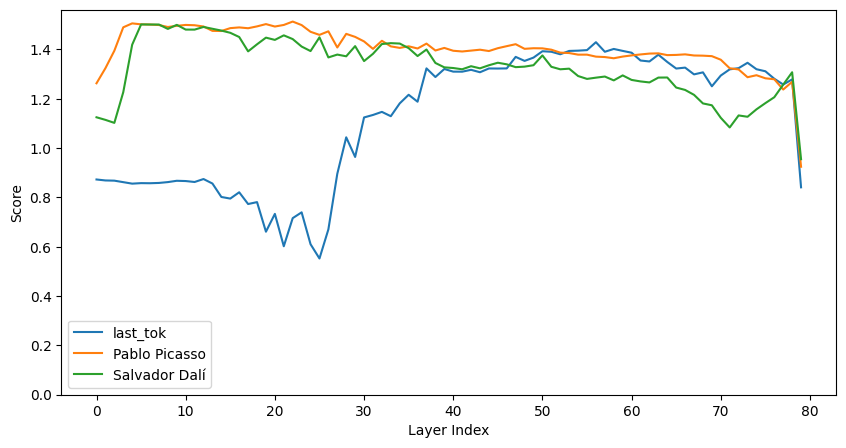

In [38]:
from src.trace import rank_reward
from matplotlib import pyplot as plt
import numpy as np

# METRIC = "prob"
METRIC = "logit"

category_scores = {category: [] for category in token_ranges.keys()}

for layer_idx in layer_indices:
    for key, token_range in token_ranges.items():
        cur_score = None
        for patch_from in token_range:
            # print(key, patch_from, layer_idx)
            ll_pred, ll_track = score_track[key][patch_from][layer_idx]
            score = getattr(ll_track[track_toks[0]][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score / denom
            # rank = ll_track[track_tok][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)


plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores)  # / max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)

In [39]:
ll_track

{15506: (10,
  PredictedToken(token=' Spanish', prob=0.0135498046875, logit=8.5, token_id=15506, metadata=None))}

## Utility

In [14]:
from src.functional import interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal
from src.functional import generate_with_patch, PatchSpec


@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs,
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt=mt,
            inputs=inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches=patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False,  # don't need to
            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f'"{answer[0]}"')

    logits = get_hs(
        mt=mt,
        input=inputs,
        locations=[(mt.lm_head_name, -1)],
        patches=patches,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt, logits=logits, interested_tokens=ans_tokens, **next_tok_kwargs
    )

    score = get_score(logits=logits, token_id=ans_tokens, metric=metric)

    return score, pred, track


gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=[],
    ans_tokens=[next_probs[0].token_id],
    generate_full_ans=False,
    metric=METRIC,
    k=15,
)

print(f"{gold_score=}")
gold_pred

gold_score=22.375


[PredictedToken(token=' Spanish', prob=0.953125, logit=22.375, token_id=15506, metadata=None),
 PredictedToken(token=' Artist', prob=0.01055908203125, logit=17.875, token_id=29459, metadata=None),
 PredictedToken(token=' nationality', prob=0.00823974609375, logit=17.625, token_id=59343, metadata=None),
 PredictedToken(token=' Span', prob=0.00640869140625, logit=17.375, token_id=12168, metadata=None),
 PredictedToken(token=' Spain', prob=0.005645751953125, logit=17.25, token_id=18157, metadata=None),
 PredictedToken(token=' Painter', prob=0.003021240234375, logit=16.625, token_id=97864, metadata=None),
 PredictedToken(token=' National', prob=0.0026702880859375, logit=16.5, token_id=5165, metadata=None),
 PredictedToken(token=' artist', prob=0.00152587890625, logit=15.9375, token_id=10255, metadata=None),
 PredictedToken(token=' profession', prob=0.0013427734375, logit=15.8125, token_id=4913, metadata=None),
 PredictedToken(token=' Barcelona', prob=0.00118255615234375, logit=15.6875, tok

## independent enrichment vs countring

In [53]:
from src.functional import get_hs
from src.tokens import find_token_range, prepare_input
from itertools import product

entity_idx = 1
entity = probing_input.entities[entity_idx]
patch_prompt = " " + entity

patch_inputs = prepare_input(
    prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
)

offset_mapping = patch_inputs.pop("offset_mapping")[0]
patch_from_range = find_token_range(
    string=patch_prompt,
    substring=entity,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,
)

logger.debug(
    f'{patch_from_range=} | "{mt.tokenizer.decode(patch_inputs.input_ids[0][range(*patch_from_range)])}"'
)

patch_hs = get_hs(
    mt=mt,
    input=patch_inputs,
    locations=list(product(mt.layer_names, list(range(*patch_from_range)))),
    return_dict=True,
)


patchs = []

patch_to_range = probing_input.entity_ranges[entity_idx]
for patch_to in range(*patch_to_range):
    patch_from = (
        patch_to - patch_to_range[0] + patch_from_range[0]
    )  # adjust to patch_inputs range
    logger.debug(
        f'patch_from="{mt.tokenizer.decode(patch_inputs.input_ids[0][patch_from])}" | patch_to="{mt.tokenizer.decode(probing_input.tokenized["input_ids"][0][patch_to])}"'
    )
    for layer in mt.layer_names:
        patchs.append(
            PatchSpec(
                location=[layer, patch_to],
                patch=patch_hs[(layer, patch_from)],
            )
        )

patch_score, patch_pred, patch_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=patchs,
    ans_tokens=[next_probs[0].token_id],
    metric=METRIC,
    k=15,
)

print(f"{patch_score=}")
indirect_effect = patch_score / gold_score
print(f"{indirect_effect=}")

patch_pred

2025-06-30 13:44:04 __main__ DEBUG    patch_from_range=(1, 3) | " Chopin"


2025-06-30 13:44:05 __main__ DEBUG    patch_from=" Chop" | patch_to=" Chop"
2025-06-30 13:44:05 __main__ DEBUG    patch_from="in" | patch_to="in"
patch_score=23.75
indirect_effect=0.9547738693467337


[PredictedToken(token=' Yes', prob=0.84375, logit=23.75, token_id=7566, metadata=None),
 PredictedToken(token=' No', prob=0.146484375, logit=22.0, token_id=2360, metadata=None),
 PredictedToken(token=' "', prob=0.0030517578125, logit=18.125, token_id=330, metadata=None),
 PredictedToken(token=' (', prob=0.0003643035888671875, logit=16.0, token_id=320, metadata=None),
 PredictedToken(token=' ', prob=0.0003643035888671875, logit=16.0, token_id=220, metadata=None),
 PredictedToken(token=' They', prob=0.0003643035888671875, logit=16.0, token_id=2435, metadata=None),
 PredictedToken(token=' Both', prob=0.00026702880859375, logit=15.6875, token_id=11995, metadata=None),
 PredictedToken(token=' \n', prob=0.00026702880859375, logit=15.6875, token_id=720, metadata=None),
 PredictedToken(token=' \n\n', prob=0.00018310546875, logit=15.3125, token_id=4815, metadata=None),
 PredictedToken(token=' yes', prob=0.000171661376953125, logit=15.25, token_id=10035, metadata=None),
 PredictedToken(token=' T

In [48]:
from src.functional import patchscope

context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

context_nat = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Imran Khan -> Pakistani
placeholder ->"""

layer_idx = 15
patch_layers = [5]
# patch_layers = list(range(5, 16))

token_idx = patch_from_range[1] - 1
h = patch_hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

# token_idx = patch_to_range[1] - 1
# # token_idx = -1
# h = hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

patchscope(
    mt=mt,
    h=h,
    context=context_prof,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    add_orig_latent_to=mt.layer_name_format.format(layer_idx),
    k=15,
)

[PredictedToken(token=' artist', prob=0.796875, logit=21.625, token_id=10255, metadata=None),
 PredictedToken(token=' painter', prob=0.1572265625, logit=20.0, token_id=30581, metadata=None),
 PredictedToken(token=' surre', prob=0.034912109375, logit=18.5, token_id=25139, metadata=None),
 PredictedToken(token=' Surre', prob=0.0013580322265625, logit=15.25, token_id=55166, metadata=None),
 PredictedToken(token=' Artist', prob=0.00127410888671875, logit=15.1875, token_id=29459, metadata=None),
 PredictedToken(token=' visual', prob=0.0009918212890625, logit=14.9375, token_id=9302, metadata=None),
 PredictedToken(token=' (', prob=0.0009918212890625, logit=14.9375, token_id=320, metadata=None),
 PredictedToken(token='artist', prob=0.000774383544921875, logit=14.6875, token_id=19135, metadata=None),
 PredictedToken(token=' ', prob=0.0005645751953125, logit=14.375, token_id=220, metadata=None),
 PredictedToken(token=' Painter', prob=0.0004138946533203125, logit=14.0625, token_id=97864, metadat

In [43]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)
print("=" * 50)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
print([mt.tokenizer.decode(t) for t in track_toks])


context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
# layer_indices = list(range(mt.n_layer))
layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 6))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

context_dict = {
    "profession": context_prof,
    "nationality": context_nat,
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:

            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"]'
            )

            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            for attr, context in context_dict.items():
                ll_pred, ll_track = patchscope(
                    mt=mt,
                    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)],
                    context=context,
                    placeholder="placeholder",
                    # context_tokenized=context_tok,
                    # placeholder_idx=h_idx,
                    patch_layers=patch_layers,
                    # add_orig_latent_to=mt.layer_names[-1], # logit lens
                    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
                    k=15,
                    interested_tokens=track_toks,
                )
                ll_fmt = [
                    f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                    for pred in ll_pred
                ]
                if token_idx not in score_track[key]:
                    score_track[key][token_idx] = []
                score_track[key][token_idx].append((ll_pred, ll_track))
                print(f"{attr} => {ll_fmt}")

        print()

    print("-" * 50)

Pablo Picasso => " Spanish"[15506] (p=0.996, logit=24.375)
Salvador Dalí => " Spanish"[15506] (p=0.992, logit=24.875)
[' Spanish']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"]
profession => ['"?\n"[p=0.20, l=13.25]', '"?\n\n"[p=0.11, l=12.69]', '"?"[p=0.06, l=12.06]', '" -\n"[p=0.04, l=11.69]', '" \n"[p=0.02, l=11.19]', '" -"[p=0.02, l=11.06]', '" -\n\n"[p=0.02, l=11.00]', '" ("[p=0.02, l=10.88]', '"??"[p=0.02, l=10.81]', '" lawyer"[p=0.02, l=10.69]', '" computer"[p=0.01, l=10.50]', '" artist"[p=0.01, l=10.50]', '" software"[p=0.01, l=10.38]', '" politician"[p=0.01, l=10.31]', '" "[p=0.01, l=10.31]']
nationality => ['"?\n"[p=0.22, l=15.19]', '"?"[p=0.11, l=14.50]', '"?\n\n"[p=0.08, l=14.12]', '" -\n"[p=0.05, l=13.62]', '" -"[p=0.04, l=13.44]', '" ("[p=0.04, l=13.38]', '" Indian"[p=0.03, l=13.31]', '"??"[p=0.03, l=13.31]', '" British"[p=0.03, l=13.19]', '" \n"[p=0.02, l=13.00]', '" French"[p=0.02, l=12.69]', '" -\n\n"[p=0.01, l=12.44]', '" Russian"[p=0.01, l=

In [51]:
patch_layers

[5]

In [114]:
layer_idx = 35

h1 = torch.stack(
    [
        hs[(mt.layer_name_format.format(layer_idx), token_idx)]
        for token_idx in range(*probing_input.entity_ranges[0])
        # for token_idx in [probing_input.entity_ranges[0][1] - 1]
    ]
).mean(dim=0)

h2 = torch.stack(
    [
        hs[(mt.layer_name_format.format(layer_idx), token_idx)]
        for token_idx in range(*probing_input.entity_ranges[1])
        # for token_idx in [probing_input.entity_ranges[1][1] - 1]
    ]
).mean(dim=0)

h_norm_mean = ((h1 + h2) / 2).norm()
h1 = (h1 / h1.norm()) * h_norm_mean
h2 = (h2 / h2.norm()) * h_norm_mean

patchscope(
    mt=mt,
    h=h1 + h2,
    # h = h2,
    # context=context_prof,
    context=context_nat,
    placeholder="placeholder",
    # context_tokenized=context_tok,
    # placeholder_idx=h_idx,
    patch_layers= [
        mt.layer_name_format.format(layer_idx) for layer_idx in patch_layers
    ],
    # add_orig_latent_to=mt.layer_names[-1], # logit lens
    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
    k=15,
    interested_tokens=track_toks,
)

([PredictedToken(token=' French', prob=0.37890625, logit=17.75, token_id=8753, metadata=None),
  PredictedToken(token=' Polish', prob=0.333984375, logit=17.625, token_id=33084, metadata=None),
  PredictedToken(token=' Swiss', prob=0.045166015625, logit=15.625, token_id=30791, metadata=None),
  PredictedToken(token=' German', prob=0.045166015625, logit=15.625, token_id=6063, metadata=None),
  PredictedToken(token='?\n', prob=0.032958984375, logit=15.3125, token_id=18072, metadata=None),
  PredictedToken(token='??', prob=0.015625, logit=14.5625, token_id=9602, metadata=None),
  PredictedToken(token='?', prob=0.0146484375, logit=14.5, token_id=949, metadata=None),
  PredictedToken(token=' (', prob=0.0137939453125, logit=14.4375, token_id=320, metadata=None),
  PredictedToken(token=' Austrian', prob=0.00787353515625, logit=13.875, token_id=58069, metadata=None),
  PredictedToken(token=' Not', prob=0.00421142578125, logit=13.25, token_id=2876, metadata=None),
  PredictedToken(token=' \n', p

In [55]:
from src.probing.prompt import ProbingPrompt


def patch_entity_from_different_run(
    mt: ModelandTokenizer,
    probing_input: ProbingPrompt,
    patch_entity_idx: int = 1,
    different_context: str = " {}",
    answer_token: int = None,
    track_tokens: list[int] = [],
    metric: Literal["logit", "prob"] = "logit",
) -> float:
    """
    Patches the entity in the connection setting with latents cached from a different context.
    Returns the indirect effect on the original output.
    """
    from src.functional import get_hs, PatchSpec
    from src.utils.typing import TokenizerOutput
    from src.tokens import prepare_input, find_token_range

    if answer_token is None:
        pred = predict_next_token(
            mt=mt,
            inputs=TokenizerOutput(data=probing_input.tokenized),
        )
        answer_token = pred[0][0].token_id  # take the first token prediction

    logger.debug(
        f'Answer token: {answer_token} ["{mt.tokenizer.decode(answer_token)}"]'
    )
    track_tokens = list(
        set(track_tokens + [answer_token])
    )  # ensure answer token is in track tokens

    # Run the clean probing input to get the gold score
    gold_score, gold_pred, gold_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=[],
        ans_tokens=track_tokens,
        metric=metric,
    )

    pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]' for pred in gold_pred
    ]
    logger.debug(f"Gold score: {gold_score} | Predicted: {pred_fmt[:5]}")

    # Cache the latents for the patch entity from a different context
    entity = probing_input.entities[patch_entity_idx]
    patch_prompt = different_context.format(entity)
    patch_inputs = prepare_input(
        prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
    )

    offset_mapping = patch_inputs.pop("offset_mapping")[0]
    patch_from_range = find_token_range(
        string=patch_prompt,
        substring=entity,
        tokenizer=mt.tokenizer,
        offset_mapping=offset_mapping,
    )

    # Cache latents from different context
    patch_hs = get_hs(
        mt=mt,
        input=patch_inputs,
        locations=[
            (layer, token_idx)
            for layer in mt.layer_names
            for token_idx in range(*patch_from_range)
        ],
        return_dict=True,
    )

    # Patch the entity in the probing input with the cached latents
    patches = []
    patch_to_range = probing_input.entity_ranges[patch_entity_idx]

    for patch_to in range(*patch_to_range):
        patch_from = (
            patch_to - patch_to_range[0] + patch_from_range[0]
        )  # adjust indices
        for layer in mt.layer_names:
            patches.append(
                PatchSpec(
                    location=[layer, patch_to],
                    patch=patch_hs[(layer, patch_from)],
                )
            )

    # Run the patched probing input to get the patched score
    patch_score, patch_pred, patch_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=patches,
        ans_tokens=track_tokens,
        metric=metric,
    )

    patch_pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]' for pred in patch_pred
    ]
    logger.debug(f"Patched score: {patch_score} | Predicted: {patch_pred_fmt[:5]}")

    indirect_effect = patch_score / gold_score

    return indirect_effect, patch_pred, patch_track


patch_entity_from_different_run(
    mt=mt,
    probing_input=probing_input,
    patch_entity_idx=1,
    different_context=" {}",
    metric="logit",
)

2025-06-27 15:07:39 __main__ DEBUG    Answer token: 7566 [" Yes"]
2025-06-27 15:07:39 __main__ DEBUG    Gold score: 20.875 | Predicted: ['" Yes"[p=0.83, l=20.88]', '" No"[p=0.13, l=19.00]', '"?"[p=0.00, l=15.75]', '"??"[p=0.00, l=15.69]', '" ("[p=0.00, l=15.62]']
2025-06-27 15:07:39 __main__ DEBUG    Patched score: 20.75 | Predicted: ['" Yes"[p=0.87, l=20.75]', '" No"[p=0.09, l=18.50]', '"?"[p=0.00, l=15.56]', '" ""[p=0.00, l=15.44]', '"??"[p=0.00, l=15.38]']


(0.9940119760479041,
 [PredictedToken(token=' Yes', prob=0.8671875, logit=20.75, token_id=7566, metadata=None),
  PredictedToken(token=' No', prob=0.09130859375, logit=18.5, token_id=2360, metadata=None),
  PredictedToken(token='?', prob=0.00482177734375, logit=15.5625, token_id=949, metadata=None),
  PredictedToken(token=' "', prob=0.0042724609375, logit=15.4375, token_id=330, metadata=None),
  PredictedToken(token='??', prob=0.003997802734375, logit=15.375, token_id=9602, metadata=None)],
 {7566: (1,
   PredictedToken(token=' Yes', prob=0.8671875, logit=20.75, token_id=7566, metadata=None))})

In [46]:
import numpy as np

indirect_effects = []

yes_token = 7566
no_token = 2360

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")
    query_sample = sample.common_entity, sample.patched_entity
    probing_input = prepare_probing_input(
        mt=mt,
        entities=query_sample,
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        # answer_prefix=" Yes -",
    )

    gold_pred = predict_next_token(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
    )[0]
    answer_token = gold_pred[0].token_id  # take the first token prediction
    if answer_token != yes_token:
        pred_fmt = [
            f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
            for pred in gold_pred
        ]
        logger.warning(f"Skipping - didn't predict `\" Yes\"`: {pred_fmt[:5]}")
        print("x" * 50)
        continue

    indirect_effect, patch_pred, patch_track = patch_entity_from_different_run(
        mt=mt,
        probing_input=probing_input,
        patch_entity_idx=1,         #! entity index
        different_context=" {}",
        answer_token=sample.patched_answer_toks[0],
        track_tokens=[yes_token, no_token],
        metric="logit",
    )

    print(f"{query_sample} => {indirect_effect}")
    print("-" * 50)

    indirect_effects.append(indirect_effect)


np.mean(indirect_effects), np.std(indirect_effects)

0 => Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
2025-06-27 14:58:21 __main__ DEBUG    Answer token: 29422 [" Urban"]
2025-06-27 14:58:21 __main__ DEBUG    Gold score: 14.1875 | Predicted: ['" Yes"[p=0.89, l=21.25]', '" No"[p=0.06, l=18.62]', '"??"[p=0.00, l=16.00]', '"?"[p=0.00, l=15.94]', '" ""[p=0.00, l=15.81]']
2025-06-27 14:58:22 __main__ DEBUG    Patched score: 13.9375 | Predicted: ['" Yes"[p=0.91, l=21.12]', '" No"[p=0.05, l=18.25]', '"??"[p=0.01, l=16.00]', '" \n"[p=0.00, l=15.81]', '" ""[p=0.00, l=15.81]']
('Grace Wanjiru', 'Fatima Sheikh') => 0.9823788546255506
--------------------------------------------------
1 => Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2025-06-27 14:58:23 __main__ DEBUG    Answer token: 16803 [" Civil"]
2025-06-27 14:58:23 __main__ DEBUG    Gold score: 14.5 | Predicted: ['" Yes"[p=0.95, l=21.38]', '" No"[p=0.03, l=17.88]', '" ""[p=0.00, l=15.56]', '"??"[p=0.00, l=15.25]', '"?"[p=0.00, l=15.25]

(np.float64(0.9821998144296827), np.float64(0.01307399470861126))

## Fuse SAE

In [65]:
from huggingface_hub import snapshot_download

sae_key = "Goodfire/Llama-3.3-70B-Instruct-SAE-l50"
sae_dir = os.path.join(env_utils.DEFAULT_MODELS_DIR, "sae", sae_key)

# snapshot_download(
#     repo_id=sae_key,
#     local_dir=sae_dir,
#     revision="main",
# )

! ls -lh {sae_dir}

total 4.1G
-rw-r--r-- 1 arnab research  480 Jun 27 15:08 config.yaml
-rw-r--r-- 1 arnab research 4.1G Jun 27 15:08 Llama-3.3-70B-Instruct-SAE-l50.pt
-rw-r--r-- 1 arnab research 3.3K Jun 27 15:08 README.md


In [66]:
class SparseAutoEncoder(torch.nn.Module):
    def __init__(
        self,
        d_in: int,
        d_hidden: int,
        device: torch.device,
        dtype: torch.dtype = torch.bfloat16,
    ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.device = device
        self.encoder_linear = torch.nn.Linear(d_in, d_hidden)
        self.decoder_linear = torch.nn.Linear(d_hidden, d_in)
        self.dtype = dtype
        self.to(self.device, self.dtype)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode a batch of data using a linear, followed by a ReLU."""
        return torch.nn.functional.relu(self.encoder_linear(x))

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """Decode a batch of data using a linear."""
        return self.decoder_linear(x)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """SAE forward pass. Returns the reconstruction and the encoded features."""
        f = self.encode(x)
        return self.decode(f), f


def load_sae(
    path: str,
    device: torch.device = torch.device("cpu"),
    dtype: torch.dtype = torch.bfloat16,
):
    sae_dict = torch.load(path, weights_only=True, map_location=device)
    sae = SparseAutoEncoder(
        d_in=sae_dict["encoder_linear.weight"].shape[1],
        d_hidden=sae_dict["encoder_linear.weight"].shape[0],
        device=device,
        dtype=dtype,
    )
    sae.load_state_dict(sae_dict)

    return sae


sae = load_sae(
    path = os.path.join(sae_dir, "Llama-3.3-70B-Instruct-SAE-l50.pt"),
    device="cuda:7",
    dtype=mt.dtype,
)

In [83]:
from src.functional import get_module_nnsight
from dataclasses import dataclass

@dataclass(frozen=False)
class SAE_Intervention:
    basis_idx: int
    token_idx: int
    set_value: float = 1.0

@torch.inference_mode()
def forward_with_sae(
    mt: ModelandTokenizer,
    sae: SparseAutoEncoder,
    input: str | TokenizerOutput,
    hook_point: str = mt.layer_name_format.format(50),
    sae_interventions: list[SAE_Intervention] = [],
    return_orig_activations: bool = False,
):
    if isinstance(input, str):
        input = prepare_input(prompts=input, tokenizer=mt)
    elif isinstance(input, TokenizerOutput):
        if "offset_mapping" in input:
            input.pop("offset_mapping")
    else:
        raise ValueError("Input must be a string or TokenizerOutput.")

    internvention_token_indices = list(set([it.token_idx for it in sae_interventions]))
    if -1 not in internvention_token_indices:
        internvention_token_indices.append(-1)
    sae_latents = {tok_idx: None for tok_idx in internvention_token_indices}
    orig_sae_latents = {tok_idx: None for tok_idx in internvention_token_indices}

    with mt.trace(input) as trace:
        module = get_module_nnsight(mt, hook_point)
        sae_input = module.output[0]

        for token_idx in internvention_token_indices:
            sae_latents[token_idx] = sae.encode(sae_input[:, token_idx, :]).save()
            orig_sae_latents[token_idx] = sae_latents[token_idx].clone().save()

        for intervention in sae_interventions:
            sae_latents[intervention.token_idx][
                :, intervention.basis_idx
            ] = intervention.set_value

        for token_idx, sae_latent in sae_latents.items():
            sae_output = sae.decode(sae_latent)
            module.output[0][:, token_idx, :] = sae_output

        # sae_output = sae.decode(sae_latent)
        # module.output[0][...] = sae_output

        output = mt.output.save()

    free_gpu_cache()

    if return_orig_activations:
        return output, sae_latents, orig_sae_latents
    return output


output = forward_with_sae(
    mt=mt,
    sae=sae,
    # input = input
    input=TokenizerOutput(data=probing_input.tokenized),
    hook_point=mt.layer_name_format.format(60),
)

interpret_logits(tokenizer=mt, logits=output.logits[:, -1], k=15)

[PredictedToken(token=' Spanish', prob=0.40625, logit=17.625, token_id=15506, metadata=None),
 PredictedToken(token=' Artist', prob=0.1318359375, logit=16.5, token_id=29459, metadata=None),
 PredictedToken(token=' Art', prob=0.10302734375, logit=16.25, token_id=5277, metadata=None),
 PredictedToken(token=' Painter', prob=0.0908203125, logit=16.125, token_id=97864, metadata=None),
 PredictedToken(token=' Spain', prob=0.037841796875, logit=15.25, token_id=18157, metadata=None),
 PredictedToken(token=' nationality', prob=0.03564453125, logit=15.1875, token_id=59343, metadata=None),
 PredictedToken(token=' National', prob=0.0260009765625, logit=14.875, token_id=5165, metadata=None),
 PredictedToken(token=' profession', prob=0.016845703125, logit=14.4375, token_id=4913, metadata=None),
 PredictedToken(token=' Barcelona', prob=0.01483154296875, logit=14.3125, token_id=28035, metadata=None),
 PredictedToken(token=' artist', prob=0.01226806640625, logit=14.125, token_id=10255, metadata=None),


In [68]:
from src.utils.env_utils import load_env_var
import goodfire

gf_client = goodfire.Client(load_env_var("GOODFIRE_KEY"))

In [69]:
nationality_features = gf_client.features.search('nationality of a person', model=model_key, top_k=30)
profession_features = gf_client.features.search('profession of a person', model=model_key, top_k=30)

2025-06-30 14:04:34 asyncio DEBUG    Using selector: EpollSelector
2025-06-30 14:04:34 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-06-30 14:04:34 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-06-30 14:04:34 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None


2025-06-30 14:04:34 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f46701a2810>
2025-06-30 14:04:34 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7f4650194560> server_hostname='api.goodfire.ai' timeout=10
2025-06-30 14:04:34 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f465058cad0>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_headers.complete
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_body.complete
2025-06-30 14:04:34 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    receive_response_headers.complete return_value

In [70]:
nationality_features

FeatureGroup([
   0: "Nationality adjectives used as attributive descriptors",
   1: "Nationality and country name suffixes",
   2: "Nationality and ethnicity markers in cross-cultural contexts",
   3: "Discussions of nationalism and national identity across languages",
   4: "National cultural identity adjectives",
   5: "Biographical introductory phrases, especially nationality and profession",
   6: "Romance language suffixes indicating nationality or profession",
   7: "Cross-lingual detection of nationalism and national identity concepts",
   8: "Legal status and rights of non-citizens and residents",
   ...
   29: "Personal pronouns and informal speech markers across multiple languages"
])

In [71]:
profession_features

FeatureGroup([
   0: "Professional and creative occupations",
   1: "Professional qualification terms in job-related contexts",
   2: "Professional expressions of taking responsibility or commitment",
   3: "Listing professional qualifications or job responsibilities, especially in healthcare",
   4: "The assistant taking professional responsibility or making commitments",
   5: "Expressions of having moral or professional obligations",
   6: "Professional offering capabilities or services to clients",
   7: "Formal expressions of commitment or dedication in professional contexts",
   8: "Descriptions of someone's professional capabilities and achievements",
   ...
   29: "Professional and formal qualities in communication and performance"
])

In [72]:
probing_input.entity_ranges

((247, 249), (250, 252))

In [84]:
amplify_feature = profession_features
suppress_feature = nationality_features

# amplify_feature, suppress_feature = suppress_feature, amplify_feature

sae_interventions = []

for feature in suppress_feature:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature.index_in_sae,
            token_idx=-1,
            set_value=0,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

################################
set_val = 2.0
################################
for feature in amplify_feature:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature.index_in_sae,
            token_idx=-1,
            set_value=set_val,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

output, modified_latents, orig_latents = forward_with_sae(
    mt = mt, sae = sae, 
    input = TokenizerOutput(data=probing_input.tokenized),
    sae_interventions=sae_interventions,
    return_orig_activations=True,
    hook_point=mt.layer_name_format.format(50),
)

interpret_logits(
    tokenizer=mt,
    logits = output.logits[:, -1],
    k=15
)

[PredictedToken(token=' Spanish', prob=0.6015625, logit=18.625, token_id=15506, metadata=None),
 PredictedToken(token=' -', prob=0.07177734375, logit=16.5, token_id=482, metadata=None),
 PredictedToken(token=' in', prob=0.04345703125, logit=16.0, token_id=304, metadata=None),
 PredictedToken(token=' nationality', prob=0.0299072265625, logit=15.625, token_id=59343, metadata=None),
 PredictedToken(token=' artist', prob=0.0299072265625, logit=15.625, token_id=10255, metadata=None),
 PredictedToken(token=' and', prob=0.0263671875, logit=15.5, token_id=323, metadata=None),
 PredictedToken(token=' painter', prob=0.0263671875, logit=15.5, token_id=30581, metadata=None),
 PredictedToken(token=' Artist', prob=0.0263671875, logit=15.5, token_id=29459, metadata=None),
 PredictedToken(token=' Spain', prob=0.012451171875, logit=14.75, token_id=18157, metadata=None),
 PredictedToken(token=',', prob=0.012451171875, logit=14.75, token_id=11, metadata=None),
 PredictedToken(token=' Catalan', prob=0.010

In [85]:
# for feature in suppress_feature:
for feature in amplify_feature:
    sae_index = feature.index_in_sae
    print(f"{feature.label} | index={sae_index} | orig: {orig_latents[-1][0][sae_index]}, modified: {modified_latents[-1][0][sae_index]}")

Professional and creative occupations | index=10256 | orig: 0.0, modified: 2.0
Professional qualification terms in job-related contexts | index=55979 | orig: 0.0, modified: 2.0
Professional expressions of taking responsibility or commitment | index=57645 | orig: 0.0, modified: 2.0
Listing professional qualifications or job responsibilities, especially in healthcare | index=50025 | orig: 0.0, modified: 2.0
The assistant taking professional responsibility or making commitments | index=11114 | orig: 0.0, modified: 2.0
Expressions of having moral or professional obligations | index=30865 | orig: 0.0, modified: 2.0
Professional offering capabilities or services to clients | index=10457 | orig: 0.0, modified: 2.0
Formal expressions of commitment or dedication in professional contexts | index=26441 | orig: 0.0, modified: 2.0
Descriptions of someone's professional capabilities and achievements | index=21220 | orig: 0.0, modified: 2.0
The offering of professional services or skills | index=3661

In [86]:
amplify_indices = [feature.index_in_sae for feature in amplify_feature]
suppress_indices = [feature.index_in_sae for feature in suppress_feature]

common = set(amplify_indices) & set(suppress_indices)
print(f"Common indices: {common}")

Common indices: set()


In [87]:
profession_features[0].index_in_sae

10256

In [88]:
# lookup = gf_client.features.lookup(
#     indices = [profession_features[0].index_in_sae],
#     model=model_key,
# )

In [89]:
orig_topk = orig_latents[-1].topk(50, dim=-1)
indices = orig_topk.indices[0].tolist()
lookup = gf_client.features.lookup(
    indices = indices,
    model=model_key,
)

2025-06-30 14:07:31 asyncio DEBUG    Using selector: EpollSelector
2025-06-30 14:07:31 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-06-30 14:07:31 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-06-30 14:07:31 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None
2025-06-30 14:07:31 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f4650502410>
2025-06-30 14:07:31 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7f46501948c0> server_hostname='api.goodfire.ai' timeout=10
2025-06-30 14:07:31 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f492d8c6710>
2025-06-30 14:07:31 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-06-30 14:07

In [90]:
for i, (value, index) in enumerate(zip(orig_topk.values[0], orig_topk.indices[0])):
    print(f"{index}={value:.2f} => {lookup[index.item()].label}")

14176=3.55 => Spanish historical transitions and periods of cultural change
54708=2.28 => Art historical explanations focusing on movements and their influence
36124=2.22 => Discussions of citizenship changes and naturalization processes
43285=2.12 => Character development and artistic growth narratives
13392=2.11 => The assistant is providing a list of options
2321=1.90 => Tourist itineraries and navigation instructions for Spanish cities
55137=1.84 => The assistant is providing a structured day-by-day travel itinerary
6769=1.77 => Data structure formatting elements in tables and lists
31343=1.77 => The assistant is providing a list of options
47163=1.67 => Biographical/definitional copula across languages ('was a'/'foi um'/etc)
9777=1.34 => Formal classifications and descriptions of occupations and professional roles
28822=1.34 => Traditional figure drawing and portraiture techniques, especially charcoal and pastels
41633=1.29 => Introductory phrases that precede descriptions or defi

In [107]:
# sae_latent = orig_latents[-1].squeeze()
# # for i in range(o)
# on_features = torch.nonzero(sae_latent > 0.5).squeeze().tolist()

# profession_direction = sae.decoder_linear.weight[:, profession_features[0].index_in_sae]
# nationality_direction = sae.decoder_linear.weight[:, nationality_features[0].index_in_sae]

# profession_cos_sim = []

# for idx in on_features:
#     current_direction = sae.decoder_linear.weight[:, idx]
#     cos_sim = torch.nn.functional.cosine_similarity(
#         profession_direction.unsqueeze(0), current_direction.unsqueeze(0)
#     )
#     profession_cos_sim.append((idx, cos_sim.item()))

# profession_cos_sim = sorted(profession_cos_sim, key=lambda x: x[1], reverse=True)

# # sae_basis_directions = [
# #     sae.decoder_linear.weight[:, idx] for idx in on_features
# # ]

In [113]:
nationality_indices = [
14176, 36124
]

profession_indices = [
54708, 43285, 9777, 48941
]

In [120]:
sae_interventions = []

for feature in nationality_indices:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature,
            token_idx=-1,
            set_value=0,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

################################
set_val = 10.0
################################
for feature in profession_indices:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature,
            token_idx=-1,
            set_value=set_val,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

output, modified_latents, orig_latents = forward_with_sae(
    mt = mt, sae = sae, 
    input = TokenizerOutput(data=probing_input.tokenized),
    sae_interventions=sae_interventions,
    return_orig_activations=True,
    hook_point=mt.layer_name_format.format(50),
)

interpret_logits(
    tokenizer=mt,
    logits = output.logits[:, -1],
    k=15
)

[PredictedToken(token=' Profession', prob=0.2109375, logit=19.125, token_id=50311, metadata=None),
 PredictedToken(token=' Painter', prob=0.2109375, logit=19.125, token_id=97864, metadata=None),
 PredictedToken(token=' Spanish', prob=0.1640625, logit=18.875, token_id=15506, metadata=None),
 PredictedToken(token=' Artist', prob=0.1640625, logit=18.875, token_id=29459, metadata=None),
 PredictedToken(token=' profession', prob=0.099609375, logit=18.375, token_id=4913, metadata=None),
 PredictedToken(token=' Art', prob=0.068359375, logit=18.0, token_id=5277, metadata=None),
 PredictedToken(token=' Cub', prob=0.00927734375, logit=16.0, token_id=18521, metadata=None),
 PredictedToken(token=' V', prob=0.006378173828125, logit=15.625, token_id=650, metadata=None),
 PredictedToken(token=' Painting', prob=0.004974365234375, logit=15.375, token_id=55143, metadata=None),
 PredictedToken(token=' Prof', prob=0.00439453125, logit=15.25, token_id=8626, metadata=None),
 PredictedToken(token=' Spain', p

In [ ]:
# entity_set = "[Albert Einstein, Issac Newton, Marie Curie, Michael Jordan]"
# entity_set = "[Albert Einstein, Issac Newton, Marie Curie, Alan Turing]"
# entity_set = "[Leonardo da Vinci, Pablo Picasso, Tiger Woods, Andy Warhol]"
# entity_set = "[Jon Stewart, Taylor Swift, Quentin Tarantino, Hugh Jackman]"

entity_set = "[Hugh Jackman, Tom Cruise, Brad Pitt, Scarlett Johansson]"
# entity_set = "[Hugh Jackman, Elton John, Danny DeVito, Scarlett Johansson]"

test_prompt = f"""
Find the odd one out in the following list of famous people:
{entity_set}
Ans: Elton John"""

test_prompt = f"""
Find if there is a person in the following list that does not fit the pattern of the others:
If there is no such person, answer "No". Else, answer "Yes - <name of the person> - <reason how this person doesn't fit the pattern>".
{entity_set}
Ans:"""

generate_with_patch(
    mt=mt,
    inputs=test_prompt,
    n_gen_per_prompt=1,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False,  # don't need to
    # patch_at_all_generations=True,    # will give the same result
)[0]

' Yes - Scarlett Johansson - The other three are male actors, while Scarlett Johansson is a female'

## Logit Lens w/o representation drift

In [53]:
from src.functional import patchscope
from src.tokens import prepare_input, find_token_range
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

context_nat = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Imran Khan -> Pakistani
placeholder ->"""


track_toks = []

for context in [context_prof, context_nat]:
    for entity in query_entities:
        context_subj = context.replace("placeholder", entity)
        top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
        print(f"{entity} => {top_pred}")
        track_toks.append(top_pred)
print("=" * 50)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
print([mt.tokenizer.decode(t) for t in track_toks])


context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
# layer_indices = list(range(mt.n_layer))
layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 6))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

context_dict = {
    "profession": context_prof,
    "nationality": context_nat,
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:

            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"]'
            )

            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            for attr, context in context_dict.items():
                ll_pred, ll_track = patchscope(
                    mt=mt,
                    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)],
                    context=context,
                    placeholder="placeholder",
                    # context_tokenized=context_tok,
                    # placeholder_idx=h_idx,
                    patch_layers=patch_layers,
                    # add_orig_latent_to=mt.layer_names[-1], # logit lens
                    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
                    k=15,
                    interested_tokens=track_toks,
                )
                ll_fmt = [
                    f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                    for pred in ll_pred
                ]
                if token_idx not in score_track[key]:
                    score_track[key][token_idx] = []
                score_track[key][token_idx].append((ll_pred, ll_track))
                print(f"{attr} => {ll_fmt}")

        print()

    print("-" * 50)

J. K. Rowling => " author"[3229] (p=0.648, logit=23.875)
Jimmy Carr => " comedian"[51912] (p=0.945, logit=22.000)
J. K. Rowling => " British"[8013] (p=0.914, logit=23.875)
Jimmy Carr => " British"[8013] (p=0.809, logit=22.625)
[' comedian', ' British', ' author']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"]
profession => ['"?\n"[p=0.20, l=13.31]', '"?\n\n"[p=0.12, l=12.81]', '"?"[p=0.06, l=12.12]', '" -\n"[p=0.03, l=11.56]', '" \n"[p=0.03, l=11.25]', '" -"[p=0.02, l=11.00]', '" -\n\n"[p=0.02, l=10.94]', '"??"[p=0.02, l=10.88]', '" ("[p=0.02, l=10.81]', '" lawyer"[p=0.01, l=10.69]', '" computer"[p=0.01, l=10.56]', '" software"[p=0.01, l=10.50]', '" artist"[p=0.01, l=10.50]', '" politician"[p=0.01, l=10.38]', '" "[p=0.01, l=10.31]']
nationality => ['"?\n"[p=0.22, l=15.19]', '"?"[p=0.11, l=14.50]', '"?\n\n"[p=0.08, l=14.12]', '" -\n"[p=0.04, l=13.56]', '" ("[p=0.04, l=13.38]', '" -"[p=0.04, l=13.38]', '"??"[p=0.03, l=13.31]', '" Indian"[p=0.03, l=13.31]', '" Br

In [45]:
from src.functional import get_hs

probe_pairs = {
    "profession": {
        "actress": ["Scarlett Johansson", "Natalie Portman"],
        "physicist": ["Albert Einstein", "Stephen Hawking"],
        "basketball player": ["Michael Jordan", "LeBron James"],
        "entrepreneur": ["Jack Ma", "Elon Musk"],
        "singer": ["Taylor Swift", "Adele"],
        "director": ["Steven Spielberg", "Christopher Nolan"],
        "chef": ["Gordon Ramsay", "Julia Child"],
        "tennis player": ["Serena Williams", "Roger Federer"],
        "comedian": ["Dave Chappelle", "Jerry Seinfeld"],
        "author": ["Stephen King", "J.K. Rowling"],
        "football player": ["Tom Brady", "Peyton Manning"],
    },
    "nationality": {
        "American": ["Barack Obama", "Oprah Winfrey"],
        "British": ["Winston Churchill", "William Shakespeare"],
        "French": ["Napoleon Bonaparte", "Coco Chanel"],
        "German": ["Ludwig van Beethoven", "Albert Einstein"],
        "Italian": ["Leonardo da Vinci", "Sophia Loren"],
        "Japanese": ["Akira Kurosawa", "Hayao Miyazaki"],
        "Canadian": ["Justin Trudeau", "Celine Dion"],
        "Australian": ["Hugh Jackman", "Nicole Kidman"],
        "Brazilian": ["Pelé", "Gisele Bündchen"],
        "Indian": ["Mahatma Gandhi", "A.R. Rahman"],
        "Spanish": ["Pablo Picasso", "Penélope Cruz"],
        "Russian": ["Vladimir Putin", "Leo Tolstoy"],
        "Chinese": ["Jackie Chan", "Yao Ming"],
        "Mexican": ["Frida Kahlo", "Salma Hayek"],
    },
}

probe_directions = {
    attr: {shared_attr: None for shared_attr in probe_pairs[attr].keys()}
    for attr in probe_pairs.keys()
}


attribute = "profession"
attr_prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[attribute],
    format="_3",
)

set_seed(142)
attr_prefix = attr_prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(attr_prefix)

locations = [(layer_name, -1) for layer_name in mt.layer_names]
lm_head_state = (mt.lm_head_name, -1)
locations += [lm_head_state]
locations = list(set(locations))


for shared_attr, current_query_pair in probe_pairs[attribute].items():
    current_input = prepare_probing_input(
        mt=mt,
        entities=current_query_pair,
        prefix=prefix,
        answer_marker=attr_prefix_generator.answer_marker,
        question_marker=attr_prefix_generator.question_marker,
        block_separator=attr_prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix=" Yes -",
    )

    probe_hs = get_hs(
        mt=mt,
        input=TokenizerOutput(data=current_input.tokenized),
        locations=locations,
        return_dict=True,
    )

    logits = probe_hs[(mt.lm_head_name, -1)]
    cur_top_preds = interpret_logits(
        tokenizer=mt,
        logits=logits,
        k=15,
    )
    probe_directions[attribute][shared_attr] = {
        layer_name: probe_hs[(layer_name, -1)] for layer_name in mt.layer_names
    }

    ll_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
        for pred in cur_top_preds
    ]
    print(f"{current_query_pair} => {ll_fmt[:5]}")

2025-07-01 11:33:58 src.utils.experiment_utils INFO     setting all seeds to 142


# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

## Your turn, give your answer in a single line.
['Scarlett Johansson', 'Natalie Portman'] => ['" Actress"[p=0.78, l=21.50]', '" actress"[p=0.09, l=19.38]', '" American"[p=0.06, l=19.00]', '" Acting"[p=0.01, l=17.38]', '" Actor"[p=0.01, l=17.38]']
['Albert Einstein', 'Stephen Hawking'] => ['" Phys"[p=0.64, l=20.25]', '" physicist"[p=0.06, l=17.88]', '" profession"[p=0.06, l=17.88]', '" Profession"[p=0.04, l=17.38]', '" The"[p=0.04, l=17.38]']
['Michael Jordan', 'LeBron James'] => ['" Basketball"[p=0.55, l

In [55]:
average_direction = {}
for layer_name in mt.layer_names:
    average_direction[layer_name] = torch.stack(
        [probe_directions[attribute][shared_attr][layer_name] for shared_attr in probe_pairs[attribute].keys()]
    ).mean(dim=0)

probe_directions[attribute]["average"] = average_direction

In [ ]:
for layer_name in mt.layer_names:
    h = hs[(layer_name, -1)]
    similarity_track = []
    for shared_attr, direction in probe_directions[attribute].items():
        cos_sim = torch.nn.functional.cosine_similarity(
            h.unsqueeze(0), direction[layer_name].unsqueeze(0)
        )
        similarity_track.append((shared_attr, cos_sim.item()))
    similarity_track = sorted(similarity_track, key=lambda x: x[1], reverse=True)
    print(f"{layer_name} => {similarity_track}")

model.layers.0 => [('actress', 1.0), ('physicist', 1.0), ('basketball player', 1.0), ('entrepreneur', 1.0), ('singer', 1.0)]
model.layers.1 => [('actress', 0.99609375), ('physicist', 0.99609375), ('basketball player', 0.99609375), ('singer', 0.99609375), ('director', 0.99609375)]
model.layers.2 => [('actress', 1.0), ('basketball player', 1.0), ('entrepreneur', 1.0), ('chef', 1.0), ('author', 1.0)]
model.layers.3 => [('actress', 1.0), ('entrepreneur', 1.0), ('tennis player', 1.0), ('author', 1.0), ('football player', 1.0)]
model.layers.4 => [('physicist', 1.0), ('basketball player', 1.0), ('entrepreneur', 1.0), ('chef', 1.0), ('tennis player', 1.0)]
model.layers.5 => [('actress', 1.0), ('chef', 1.0), ('author', 1.0), ('physicist', 0.99609375), ('basketball player', 0.99609375)]
model.layers.6 => [('entrepreneur', 1.0), ('chef', 1.0), ('tennis player', 1.0), ('comedian', 1.0), ('author', 1.0)]
model.layers.7 => [('average', 1.0), ('physicist', 0.99609375), ('entrepreneur', 0.99609375), (